In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential
from keras.layers import Dense

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm,

import seaborn as sns; sns.set()

from pandas.core import datetools
%matplotlib inline


# Data Acquisition
The following code imports and validates the LendingClub data.

In [3]:
converters = dict(
    id=str,
    desc=str,
    hardship_type=str,
    hardship_reason=str,
    hardship_status=str,
    hardship_loan_status=str,
    verification_status_joint=str
)
dates = [
    'next_pymnt_d',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'earliest_cr_line',
    'issue_d',
    'debt_settlement_flag_date'
]

In [4]:
# Imports loan data

df = pd.DataFrame()
basepath='./Source Data/Loan Data/'
files = os.listdir(basepath)
csvs = []

for file in files:
    if re.match('.*csv$',file):
        csvs += [file]

if 0:
    #ignore this - was trying to pickle the data into
    #formats like feather, hdf5, native python pickling, etc
    # but found issues on python 3.7
    df=pd.read_pickle(basepath+'df.pkl')
else:
    cols = df.dtypes
    for csv in csvs:
        path = basepath + csv
        print("Reading",path)
        tdf = pd.read_csv(path,header=1,parse_dates=dates,low_memory=False)
        df=df.append(tdf)
    
df.reset_index(inplace=True) # This will help with joining back data if necessary.

print(df.shape)

Reading ./Source Data/Loan Data/LoanStats3a_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3b_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3c_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3d_securev1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q2.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q3.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q4.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q2.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q3.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q4.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2018Q1.csv
(1873317, 152)


In [6]:
# Convert dates to datetime
#df['issue_d'] = pd.to_datetime(df['issue_d'])
#df['debt_settlement_flag_date'] = pd.to_datetime(df['debt_settlement_flag_date'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

#determine age of credit line prior to loan issue and convert to integer
# days of credit history
df['earliest_cr_line'] = (df['issue_d']-df['earliest_cr_line']).dt.days

# convert issue_d to a year to consider economic conditions
#SHOULD WE GO TO QUARTERS?
#df['issue_d'] = df['issue_d'].dt.year

df['duration'] = (df['issue_d'] - df['debt_settlement_flag_date']).dt.days / 30

In [16]:
# Limit to loans that are paid in full or written off. Uses dates so that 
# loans that are delinquent are not disproportionaltely dropped from data

mature_filter = (df['loan_status']=='Fully Paid')|(df['loan_status']=='Charged Off')
reduced_df = df[mature_filter] # Pulls only loans that are charged off or paid in full.
#
## Use my documentation to filter to only useful regressors
data_dict = pd.read_excel('./Source Data/LCDataDictionary.xlsx',sheet_name='LoanStats')
features = list(data_dict[data_dict['Useful Predictor']=='Yes']['LoanStatNew'].values)+['']
reduced_df=reduced_df[features]

# Combines fields when necessary
reduced_df['fico_est'] = (reduced_df['fico_range_low']+reduced_df['fico_range_high'])/2

reduced_df.drop(columns=['fico_range_low','fico_range_high'],inplace=True)
print(reduced_df.shape)

(1020552, 70)


In [17]:
# backup our df
backup_df = reduced_df.copy()

In [18]:
#restore our df
reduced_df = backup_df.copy()

In [19]:
# Convert strings to numbers emp_length, int_rate, revol_util
emp_length_map={'10+ years':10, '< 1 year':0, '1 year':1, '3 years':3, '8 years':8, '9 years':9,
                '4 years':4, '5 years':5, '6 years':6, '2 years':2, '7 years':7}

reduced_df['emp_length']=reduced_df['emp_length'].replace(pd.Series(emp_length_map))

grade_map={"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7}
reduced_df['grade']=reduced_df['grade'].replace(pd.Series(grade_map))

reduced_df['int_rate']=reduced_df['int_rate'].apply(lambda x: float(x[:-1]))
reduced_df['revol_util']=reduced_df['revol_util'].apply(lambda x:
                                                        x[:-1] if isinstance(x, str) else np.nan).astype(float)

reduced_df['earliest_cr_line']=reduced_df['earliest_cr_line'].apply(lambda x:
                                                        0.0 if np.isnan(x) else x)

reduced_df.drop(columns=['emp_title'],inplace=True)

print(reduced_df.shape)

(1020552, 69)


Based on these results, we will have to encode several data as dummy variables:

- application_type
- term
- verification_status
- home_ownership
- purpose


In [20]:
seta=set(reduced_df.columns)


# 8/8 consolidated purpose
# Consolidated where logical
reduced_df['purpose'].replace('credit_card','debt_consolidation',inplace=True)
reduced_df['purpose'].replace('educational','other',inplace=True)
reduced_df['purpose'].replace('wedding','major_purchase',inplace=True)
reduced_df['purpose'].replace('vacation','major_purchase',inplace=True)
reduced_df['purpose'].replace('moving','house',inplace=True)
reduced_df['purpose'].replace('home_improvement ','house',inplace=True)
reduced_df['purpose'].replace('renewable_energy ','house',inplace=True)

reduced_df=pd.get_dummies(data=reduced_df,columns=['application_type','term',
                                                   'verification_status','purpose'],
                          drop_first=True)

# 8/8 removed 'home_ownership
reduced_df['home_ownership'] = np.where(reduced_df['home_ownership']=='OWN',1,0)

setb=set(reduced_df.columns)
print(setb-seta)
print(reduced_df.shape)

{'purpose_renewable_energy', 'application_type_Joint App', 'verification_status_Verified', 'term_ 60 months', 'purpose_medical', 'purpose_home_improvement', 'purpose_debt_consolidation', 'purpose_small_business', 'verification_status_Source Verified', 'purpose_house', 'purpose_major_purchase', 'purpose_other'}
(1020552, 77)


# How to treat NaN?

For now, let's remove majority NaN columns...

In [21]:
has_data = {}
for column in reduced_df.columns:
    has_data[column] = len(reduced_df[column].dropna())
has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

top_sparse=25
for i,j in zip(range(top_sparse),order_has_data[0:top_sparse]):
    print(i,j, has_data[j])

0 annual_inc_joint 9529
1 dti_joint 9529
2 debt_settlement_flag_date 20908
3 mths_since_last_record 172185
4 mths_since_recent_bc_dlq 240759
5 mths_since_last_major_derog 264308
6 mths_since_rcnt_il 289098
7 all_util 296067
8 inq_last_12m 296092
9 open_acc_6m 296092
10 total_cu_tl 296092
11 inq_fi 296093
12 open_il_12m 296093
13 open_il_24m 296093
14 open_rv_12m 296093
15 open_rv_24m 296093
16 mths_since_recent_revol_delinq 338379
17 mths_since_last_delinq 503506
18 mths_since_recent_inq 881746
19 mo_sin_old_il_acct 924972
20 mo_sin_old_rev_tl_op 953024
21 mo_sin_rcnt_rev_tl_op 953024
22 num_rev_accts 953024
23 mo_sin_rcnt_tl 953025
24 num_accts_ever_120_pd 953025


In [22]:
nonnan_df=reduced_df.drop(columns=order_has_data[0:19])
print(nonnan_df.shape)

(1020552, 58)


In [23]:
# Creates interaction variable for all financial variables
df.iloc[1]['url']

'https://lendingclub.com/browse/loanDetail.action?loan_id=1077430'

# Let's work with training and test sets

In [136]:
print(df.shape,nonnan_df.shape)

# need to look at interest rate as well!!!
y=nonnan_df['total_pymnt']/(nonnan_df['installment']*36 + nonnan_df['installment']*nonnan_df['term_ 60 months']*24)
#y=nonnan_df['total_pymnt']/nonnan_df['loan_amnt']
print(features)
traintest_df=nonnan_df[features]

X_train, X_test, y_train, y_test = train_test_split(
    traintest_df,y,test_size=0.2,random_state=42)#,stratify=nonnan_df[['loan_status']])

Xscaler = StandardScaler()
Xscaler.fit_transform(X_train,X_test)

print(X_train.shape,X_test.shape)

(1873317, 153) (890451, 58)
['annual_inc', 'home_ownership', 'tax_liens', 'total_bc_limit', 'num_tl_op_past_12m', 'purpose_medical', 'mort_acc', 'emp_length', 'verification_status_Source Verified', 'purpose_major_purchase', 'collections_12_mths_ex_med', 'verification_status_Verified', 'purpose_renewable_energy', 'percent_of_income', 'mo_sin_rcnt_tl', 'earliest_cr_line', 'fico_est', 'chargeoff_within_12_mths', 'pub_rec', 'num_accts_ever_120_pd', 'purpose_house', 'num_tl_90g_dpd_24m', 'purpose_debt_consolidation', 'mo_sin_rcnt_rev_tl_op', 'int_rate', 'purpose_home_improvement', 'total_bal_ex_mort', 'total_rev_hi_lim', 'delinq_2yrs', 'percent_bc_gt_75', 'tot_coll_amt', 'pub_rec_bankruptcies', 'dti', 'purpose_small_business', 'purpose_other', 'application_type_Joint App', 'inq_last_6mths', 'mths_since_recent_bc', 'issue_d', 'term_ 60 months']
(712360, 40) (178091, 40)


In [137]:
# your code here

pca = PCA(n_components=.95,svd_solver="full")
principalComponents = pca.fit(X_train)

print("PCA used %d components to capture >95%% variance."% len(pca.components_))
print("Total variance captured = %f." % pca.explained_variance_ratio_.sum())
#print(principalComponents.components_)

X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)


PCA used 3 components to capture >95% variance.
Total variance captured = 0.959392.


In [138]:
LCOLSModel = LinearRegression().fit(X_train, y_train)

print(LCOLSModel.intercept_)
print(LCOLSModel.coef_)

# your code here
trainR2 = r2_score(y_train,LCOLSModel.predict(X_train))

testR2 = r2_score(y_test,LCOLSModel.predict(X_test))

print("The training set OLS regression R^2 score is: %f" % trainR2)
print("The test set OLS regression R^2 score is: %f" % testR2)

80.14644963938565
[-6.45297841e-09  8.09317715e-04 -4.01321614e-03  6.29255117e-08
 -4.53684460e-03 -1.91735892e-02  5.16423231e-03  9.06539896e-04
 -9.18280010e-03 -1.05063020e-02 -8.98295609e-03 -9.71710977e-03
 -2.49676923e-02 -1.31748553e-01  1.89168835e-04  6.63193527e-07
  1.21958015e-04 -1.93853320e-03  3.98146374e-03  8.65349955e-04
 -8.13636357e-03  1.23665250e-03 -1.89078585e-03 -9.81591453e-05
 -1.37042134e-02 -4.58930487e-03  6.48156435e-08  3.13728184e-09
 -3.09589285e-03 -3.84828177e-05  2.41811130e-08 -2.87438762e-03
 -1.08829947e-03 -3.78299758e-02 -1.93773979e-03  3.41364718e-02
 -4.87289585e-03  1.70757441e-04 -3.92939351e-02 -1.40158349e-01]
The training set OLS regression R^2 score is: 0.236507
The test set OLS regression R^2 score is: 0.254079


In [139]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

kfold = KFold(5, shuffle=True) # use this for testing

LCRRModel = RidgeCV(alphas=lambdas, cv=kfold)
LCRRModel.fit(X_train, y_train)
LCRR_shrinkage_parameter=LCRRModel.alpha_

print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCRR_shrinkage_parameter,
                                                                            LCRRModel.intercept_,
                                                                            LCRRModel.coef_
                                                                            )
     )

RRtrainR2 = r2_score(y_train,LCRRModel.predict(X_train))
RRtestR2 = r2_score(y_test,LCRRModel.predict(X_test))
print("The training set Ridge regression R^2 score is: %f" % RRtrainR2)
print("The test set Ridge regression R^2 score is: %f" % RRtestR2)

Best model searched:
alpha = 100
intercept = 80.10534976460974
betas = [-5.61138912e-09  7.80348538e-04 -3.99217418e-03  6.07776706e-08
 -4.49761575e-03 -1.74018630e-02  5.16712013e-03  9.09285848e-04
 -9.28972485e-03 -9.04522859e-03 -8.89397356e-03 -9.87065969e-03
 -1.89129021e-02 -1.21185978e-01  1.85963546e-04  6.62281294e-07
  1.21029941e-04 -1.89057364e-03  3.97352049e-03  8.72410120e-04
 -6.57825158e-03  1.21503464e-03 -7.11023049e-04 -9.68311635e-05
 -1.37463597e-02 -3.30624850e-03  6.64699747e-08  2.56176751e-09
 -3.07046241e-03 -3.73449174e-05  2.42317475e-08 -2.83351539e-03
 -1.10562853e-03 -3.59850902e-02 -4.53799220e-04  3.30270552e-02
 -4.83937331e-03  1.70558486e-04 -3.92739116e-02 -1.39889147e-01], 
The training set Ridge regression R^2 score is: 0.236504
The test set Ridge regression R^2 score is: 0.254343


In [140]:
LCLRModel = LassoCV(alphas=lambdas, cv=kfold)
LCLRModel.fit(X_train, y_train)
LCLR_shrinkage_parameter = LCLRModel.alpha_
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCLR_shrinkage_parameter,
                                                                            LCLRModel.intercept_,
                                                                            LCLRModel.coef_
                                                                            )
     )

LRtrainR2 = r2_score(y_train,LCLRModel.predict(X_train))
LRtestR2 = r2_score(y_test,LCLRModel.predict(X_test))
print("The training set Lasso regression R^2 score is: %f" % LRtrainR2)
print("The test set Lasso regression R^2 score is: %f" % LRtestR2)

Best model searched:
alpha = 0.001
intercept = 78.00919823341039
betas = [-2.61535584e-09  0.00000000e+00 -0.00000000e+00  7.47289566e-09
 -3.78863412e-03 -0.00000000e+00  4.81245552e-03  8.63776159e-04
 -1.62672516e-03 -0.00000000e+00 -0.00000000e+00 -1.22837820e-03
 -0.00000000e+00 -0.00000000e+00  1.44141242e-04  6.81039699e-07
  1.10846724e-04 -0.00000000e+00  0.00000000e+00  1.56427719e-04
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -6.49796019e-05
 -1.48018184e-02 -0.00000000e+00  7.54705008e-08 -2.39033783e-09
 -9.49213643e-04 -6.55927202e-06  2.58676479e-08  0.00000000e+00
 -1.27183477e-03 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.11105754e-03  1.60870751e-04 -3.82321146e-02 -1.31257371e-01], 
The training set Lasso regression R^2 score is: 0.235237
The test set Lasso regression R^2 score is: 0.254969


In [141]:
coef_df=pd.DataFrame(np.array([X_train.columns,
                               LCOLSModel.coef_,
                               LCRRModel.coef_,
                               LCLRModel.coef_]).T,columns=["feature","OLS","RR","LR"])

In [142]:
print(coef_df)

                                feature          OLS           RR           LR
0                            annual_inc -6.45298e-09 -5.61139e-09 -2.61536e-09
1                        home_ownership  0.000809318  0.000780349            0
2                             tax_liens  -0.00401322  -0.00399217           -0
3                        total_bc_limit  6.29255e-08  6.07777e-08   7.4729e-09
4                    num_tl_op_past_12m  -0.00453684  -0.00449762  -0.00378863
5                       purpose_medical   -0.0191736   -0.0174019           -0
6                              mort_acc   0.00516423   0.00516712   0.00481246
7                            emp_length   0.00090654  0.000909286  0.000863776
8   verification_status_Source Verified   -0.0091828  -0.00928972  -0.00162673
9                purpose_major_purchase   -0.0105063  -0.00904523           -0
10           collections_12_mths_ex_med  -0.00898296  -0.00889397           -0
11         verification_status_Verified  -0.00971711

TypeError: Unary negative expects numeric dtype, not object

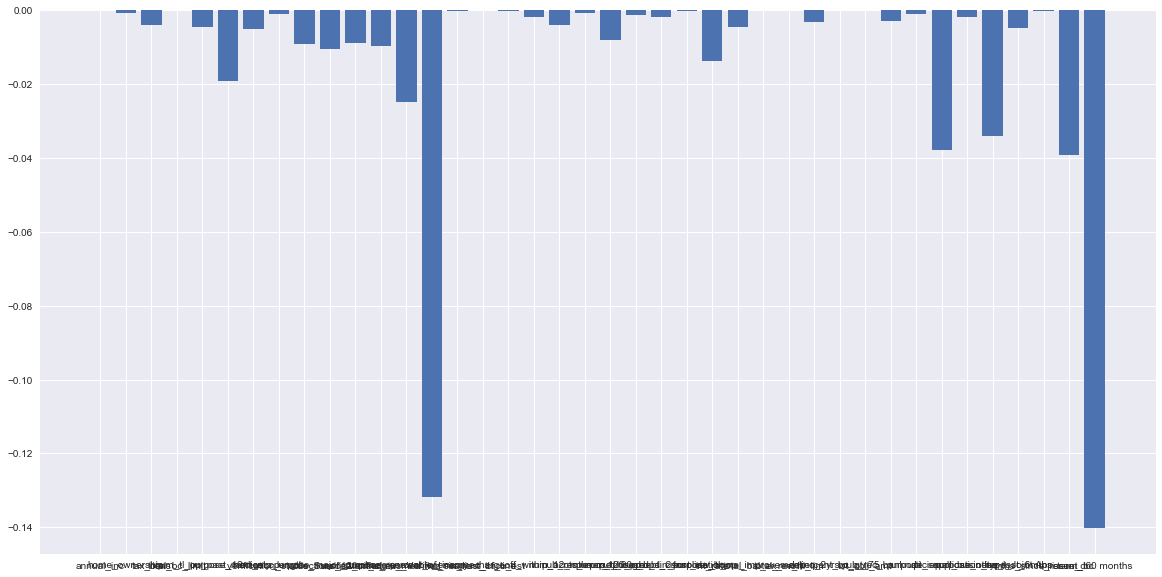

In [146]:
# your code here
plt.figure(figsize=(20,10))
plt.bar(coef_df["feature"],[-abs(x) for x in coef_df["OLS"].values],label='OLS',alpha=1.0)
plt.bar(coef_df["feature"],-abs(coef_df["RR"]),label='RR',alpha=0.5)
plt.bar(coef_df["feature"],abs(coef_df["LR"]),label='LR',alpha=0.5)
plt.yscale("linear")

plt.legend()
plt.show()

## Additional Multicolinearity Analysis
Based on the poor performance of the models. I performed additional analysis to determine the impact of multicolinearity on our data. Note: Based on this analysis, I simplified some of the dummy variables.

In [144]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.columns.shape[0])]
vif['Feature'] = X_train.columns
vif.sort_values('VIF',ascending=False)


,VIF,Feature
38,1147.732042,issue_d
16,920.219590,fico_est
22,89.167011,purpose_debt_consolidation
24,18.537946,int_rate
18,9.341365,pub_rec
25,7.621388,purpose_home_improvement
15,7.616716,earliest_cr_line
32,7.409410,dti
34,6.545750,purpose_other
13,5.180494,percent_of_income


In [145]:
corval = []
for i in X_train.columns:
    if not i == 'issue_d':
        print(i, np.corrcoef(X_train['issue_d'],X_train[i])[0][1])
        corval += [np.corrcoef(X_train['issue_d'],X_train[i])[0][1]]
print(max(corval))

# Multicolinearity is high but there are no single factors contributing
# Simply put, the quality of lenders changed as the program progressed.

annual_inc 0.04207555567145366
home_ownership 0.042704048794919666
tax_liens 0.03359571333519387
total_bc_limit 0.054025078906993096
num_tl_op_past_12m 0.11982061137996379
purpose_medical 0.01967071737999264
mort_acc -0.04335721996427418
emp_length -0.01596586184662598
verification_status_Source Verified 0.11963420629751471
purpose_major_purchase 0.01932501170704659
collections_12_mths_ex_med 0.03981895139606265
verification_status_Verified -0.10092984429947184
purpose_renewable_energy 0.0013526682141669106
percent_of_income -0.039401757889393915
mo_sin_rcnt_tl -0.06329361777349195
earliest_cr_line 0.012635889710744322
fico_est 0.034350381943480716
chargeoff_within_12_mths 0.007475703410340281
pub_rec 0.06905304660278311
num_accts_ever_120_pd 0.05125943449675208
purpose_house 0.02100879784358664
num_tl_90g_dpd_24m 0.013206162061459916
purpose_debt_consolidation -0.07256076281404199
mo_sin_rcnt_rev_tl_op -0.030083007524700195
int_rate -0.0350848267579731
purpose_home_improvement 0.03838

# Advanced Models
We continue to have problems with multicolinearity which may be contributing to some of the problems we are seeing in the data. I am going to try additional models that may be more suitable.

Because of the sheer size of our dataset, the following block of code take a long time to run. I ran one with full datasets without much luck. To reduce the runtime, I pulled a random sample from the dataset.

In [147]:
sample_percent = .20 # I put this ridiculouly low to ensure code would compile. I will run again overnight with a 
# larger number for additional insights.
X_train_sample = X_train.reset_index(drop=True).sample(int(len(X_train)*sample_percent),random_state=42)
y_train_sample = y_train.reset_index(drop=True).iloc[X_train_sample.index]

In [148]:
neu_net = Sequential([
    Dense(800, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(800, activation='relu'),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(1, activation='relu')
])
neu_net.compile(loss='mean_absolute_error', optimizer='adam')
neu_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 800)               32800     
_________________________________________________________________
dense_2 (Dense)              (None, 400)               320400    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 401       
Total params: 834,801
Trainable params: 834,801
Non-trainable params: 0
_________________________________________________________________


In [149]:
neu_net.fit(X_train_sample,y_train_sample, epochs=20, batch_size=64, validation_split = .25)


Train on 106854 samples, validate on 35618 samples
Epoch 1/20
106854/106854 [==============================] - 39s 364us/step - loss: 2.1468 - val_loss: 0.8161
Epoch 2/20
106854/106854 [==============================] - 41s 383us/step - loss: 0.8149 - val_loss: 0.8161
Epoch 3/20
106854/106854 [==============================] - 39s 364us/step - loss: 0.8149 - val_loss: 0.8161
Epoch 4/20
106854/106854 [==============================] - 39s 362us/step - loss: 0.8149 - val_loss: 0.8161
Epoch 5/20
106854/106854 [==============================] - 38s 357us/step - loss: 0.8149 - val_loss: 0.8161
Epoch 6/20
106854/106854 [==============================] - 40s 375us/step - loss: 0.8149 - val_loss: 0.8161
Epoch 7/20
106854/106854 [==============================] - 40s 373us/step - loss: 0.8149 - val_loss: 0.8161
Epoch 8/20
106854/106854 [==============================] - 38s 359us/step - loss: 0.8149 - val_loss: 0.8161
Epoch 9/20
106854/106854 [==============================] - 40s 371us/step - 

I don't see an improvement in the loss function. I'm going to try alternative methods.

In [150]:
RF_model = RandomForestRegressor(10)
RF_model.fit(X_train_sample,y_train_sample)
RF_model.score(X_test,y_test)

0.1724928527270131

In [151]:
size = []
avg_score = []
sd_score = []
for i in range(2,15):
    s = i * 4
    size += [s]
    RF_model = RandomForestRegressor(s)
    cv = cross_val_score(RF_model,X_train_sample,y_train_sample,cv=6)
    avg_score +=  [np.average(cv)]
    sd_score += [np.std(cv)]
    print(i,'complete')
    

2 complete
3 complete
4 complete
5 complete
6 complete
7 complete
8 complete
9 complete
10 complete
11 complete
12 complete
13 complete
14 complete


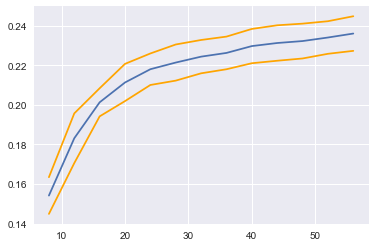

In [152]:
plt.plot(size,avg_score)
bound = []
for i in range(len(size)):
    bound += [avg_score[i]+sd_score[i]]
plt.plot(size,bound,c='orange')

bound = []
for i in range(len(size)):
    bound += [avg_score[i]-sd_score[i]]
plt.plot(size,bound,c='orange')

# Code for cleanup in the future

In [ ]:
order=sorted(has_data, key=lambda dict_key: has_data[dict_key])

for i in order:
    print(i, has_data[i])

# Heat map Visualizations

In [153]:
#Explore the loan status versus purpose
import seaborn as sns; sns.set()

purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[purp_loan[0]], df[purp_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
purpose,,,,,,,,,
car,1621,8918,0,13,51,9496,95,35,166
credit_card,38804,185798,7,69,271,182070,2503,813,3511
debt_consolidation,129606,449458,10,292,808,470267,8431,2766,11680
educational,56,1,0,32,65,270,0,0,0
home_improvement,11703,58019,3,71,143,53007,859,295,1249
house,1089,4832,0,11,33,4072,88,34,126
major_purchase,4047,19217,0,23,100,17818,259,108,468
medical,2535,10865,0,22,36,8669,169,69,266
moving,1715,5464,1,15,31,5486,118,38,165


In [154]:
# Explore the loan status versus loan grade
loan_grade = ['loan_status', 'grade']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_grade[0]], df[loan_grade[1]]).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,10831,40038,64493,47643,29714,12257,3681
Current,150647,252131,250946,105350,39290,10482,3348
Default,0,5,14,2,2,1,0
Does not meet the credit policy. Status:Charged Off,8,85,148,197,158,93,72
Does not meet the credit policy. Status:Fully Paid,90,269,481,494,378,154,122
Fully Paid,160994,254370,222484,108832,46641,14794,3780
In Grace Period,765,2929,4902,2934,1447,469,188
Late (16-30 days),252,963,1602,1011,520,186,68
Late (31-120 days),1032,3884,6880,4292,2222,871,354


In [155]:
#Explore the loan status versus home ownership
loan_home = ['loan_status', 'home_ownership']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_home[0]], df[loan_home[1]]).style.background_gradient(cmap = cm)


home_ownership,ANY,MORTGAGE,NONE,OTHER,OWN,RENT
loan_status,,,,,,
Charged Off,33,89406,7,27,22586,96598
Current,341,399110,1,0,95966,316776
Default,0,8,0,0,2,14
Does not meet the credit policy. Status:Charged Off,0,348,1,11,49,352
Does not meet the credit policy. Status:Fully Paid,0,908,4,27,138,911
Fully Paid,124,417473,40,117,83520,310621
In Grace Period,6,6421,1,0,1592,5614
Late (16-30 days),0,2148,0,0,605,1849
Late (31-120 days),8,8282,0,0,2481,8764


In [156]:
#Exploring the loan_status versus loan application_type
loan_application = ['loan_status', 'application_type']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_application[0]], df[loan_application[1]]).style.background_gradient(cmap = cm)

application_type,Individual,Joint App
loan_status,,
Charged Off,206689,1968
Current,756226,55968
Default,23,1
Does not meet the credit policy. Status:Charged Off,761,0
Does not meet the credit policy. Status:Fully Paid,1988,0
Fully Paid,804334,7561
In Grace Period,12553,1081
Late (16-30 days),4278,324
Late (31-120 days),18382,1153


In [157]:
#Exploring the State Address versus Loan Status
adress_loan = ['addr_state', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[adress_loan[0]], df[adress_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
addr_state,,,,,,,,,
AK,504,1846,0,1,4,2021,34,6,53
AL,3109,9644,0,8,24,9630,178,64,270
AR,1869,6123,0,6,9,5752,99,36,173
AZ,4950,18364,0,18,33,19889,309,101,498
CA,30436,104027,5,101,223,122155,1655,588,2663
CO,3626,16037,0,13,52,19244,209,85,306
CT,2623,14159,0,12,50,12043,271,89,283
DC,367,1729,0,2,8,2386,36,11,32
DE,570,2339,0,4,18,2233,51,16,75


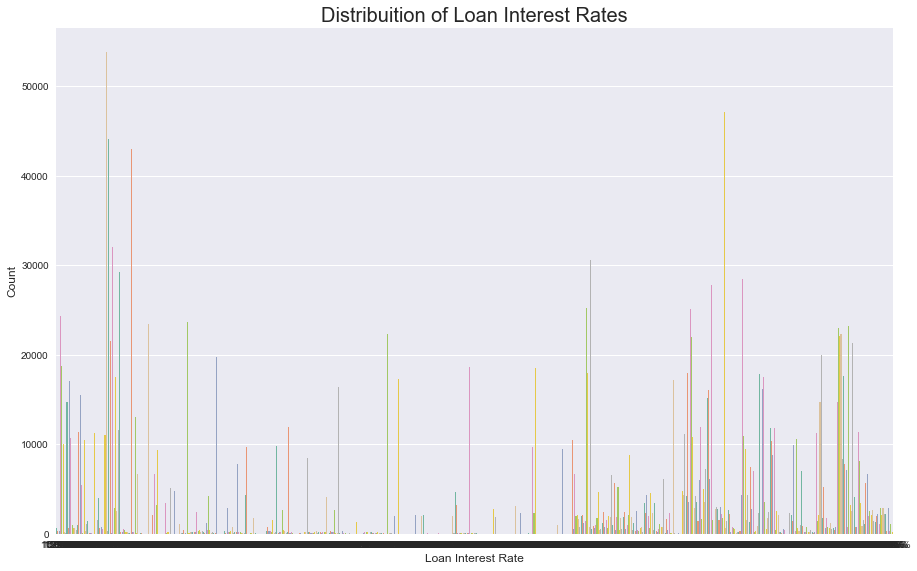

In [158]:
# Explore distrubution of loan interest rates
plt.figure(figsize = (15,12))
plt.subplot(211)
g1 = sns.countplot(x="int_rate",data=df, 
                   palette="Set2")
g1.set_xlabel("Loan Interest Rate", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Distribuition of Loan Interest Rates", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 1.2,top = 2)

plt.show()

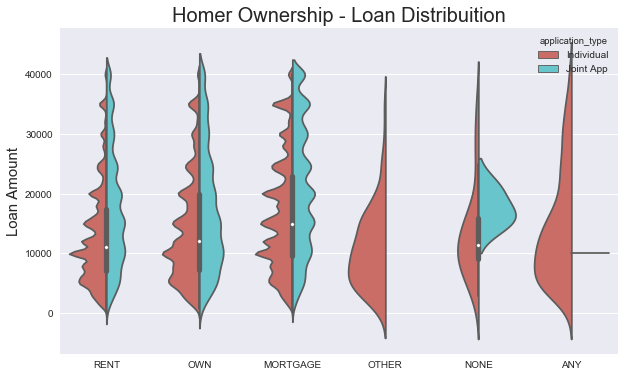

In [159]:
plt.figure(figsize = (10,6))

g = sns.violinplot(x="home_ownership",y="loan_amnt",data=df,
               kind="violin",
               split=True,palette="hls",
               hue="application_type")
g.set_title("Homer Ownership - Loan Distribuition", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.show()

Purposes count description: 
application_type    Individual  Joint App
purpose                                  
car                      19829        566
credit_card             401026      12820
debt_consolidation     1031471      41847
educational                424          0
home_improvement        120451       4898
house                     9988        297
major_purchase           40716       1324
medical                  21452       1179
moving                   12570        463
other                   110453       3703
renewable_energy          1195         38
small_business           20836        616
vacation                 12469        304
wedding                   2354          1


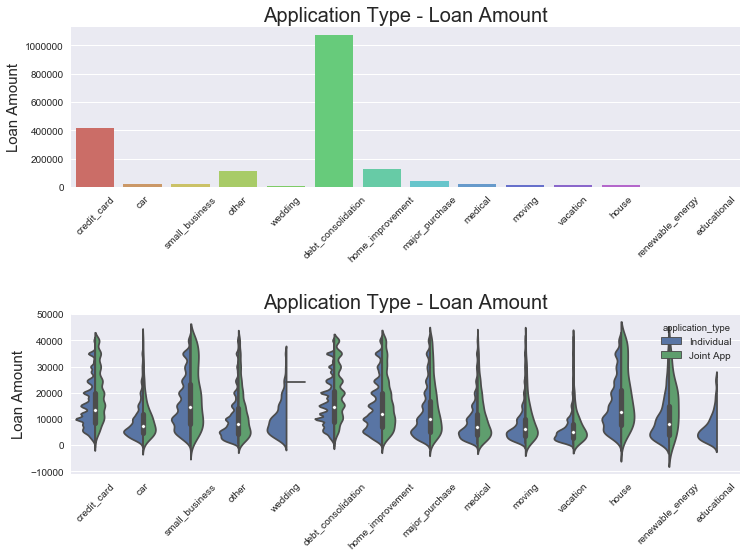

In [160]:
# Explore Loan Purpose
print("Purposes count description: ")
print(pd.crosstab(df.purpose, df.application_type))

plt.figure(figsize = (12,8))

plt.subplot(211)
g = sns.countplot(x="purpose",data=df,
                  palette='hls')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Application Type - Loan Amount", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.subplot(212)
g1 = sns.violinplot(x="purpose",y="loan_amnt",data=df,
               hue="application_type", split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_title("Application Type - Loan Amount", fontsize=20)
g1.set_xlabel("", fontsize=15)
g1.set_ylabel("Loan Amount", fontsize=15)

plt.subplots_adjust(wspace = 0.2, hspace = 0.8,top = 0.9)
plt.show()

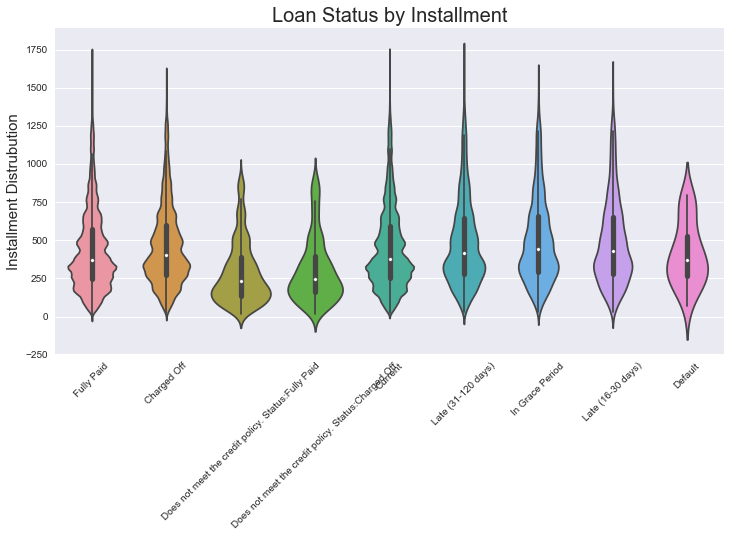

In [161]:
plt.figure(figsize = (12,6))

g = sns.violinplot(x='loan_status', y="installment",
                   data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Installment Distrubution", fontsize=15)
g.set_title("Loan Status by Installment", fontsize=20)

plt.show()

In [162]:
df.loc[df.loan_status == \
            'Does not meet the credit policy. Status:Fully Paid', 'loan_status'] = 'NMCP Fully Paid'
df.loc[df.loan_status == \
            'Does not meet the credit policy. Status:Charged Off', 'loan_status'] = 'NMCP Charged Off'

Current               812194
Fully Paid            811895
Charged Off           208657
Late (31-120 days)     19535
In Grace Period        13634
Late (16-30 days)       4602
NMCP Fully Paid         1988
NMCP Charged Off         761
Default                   24
Name: loan_status, dtype: int64


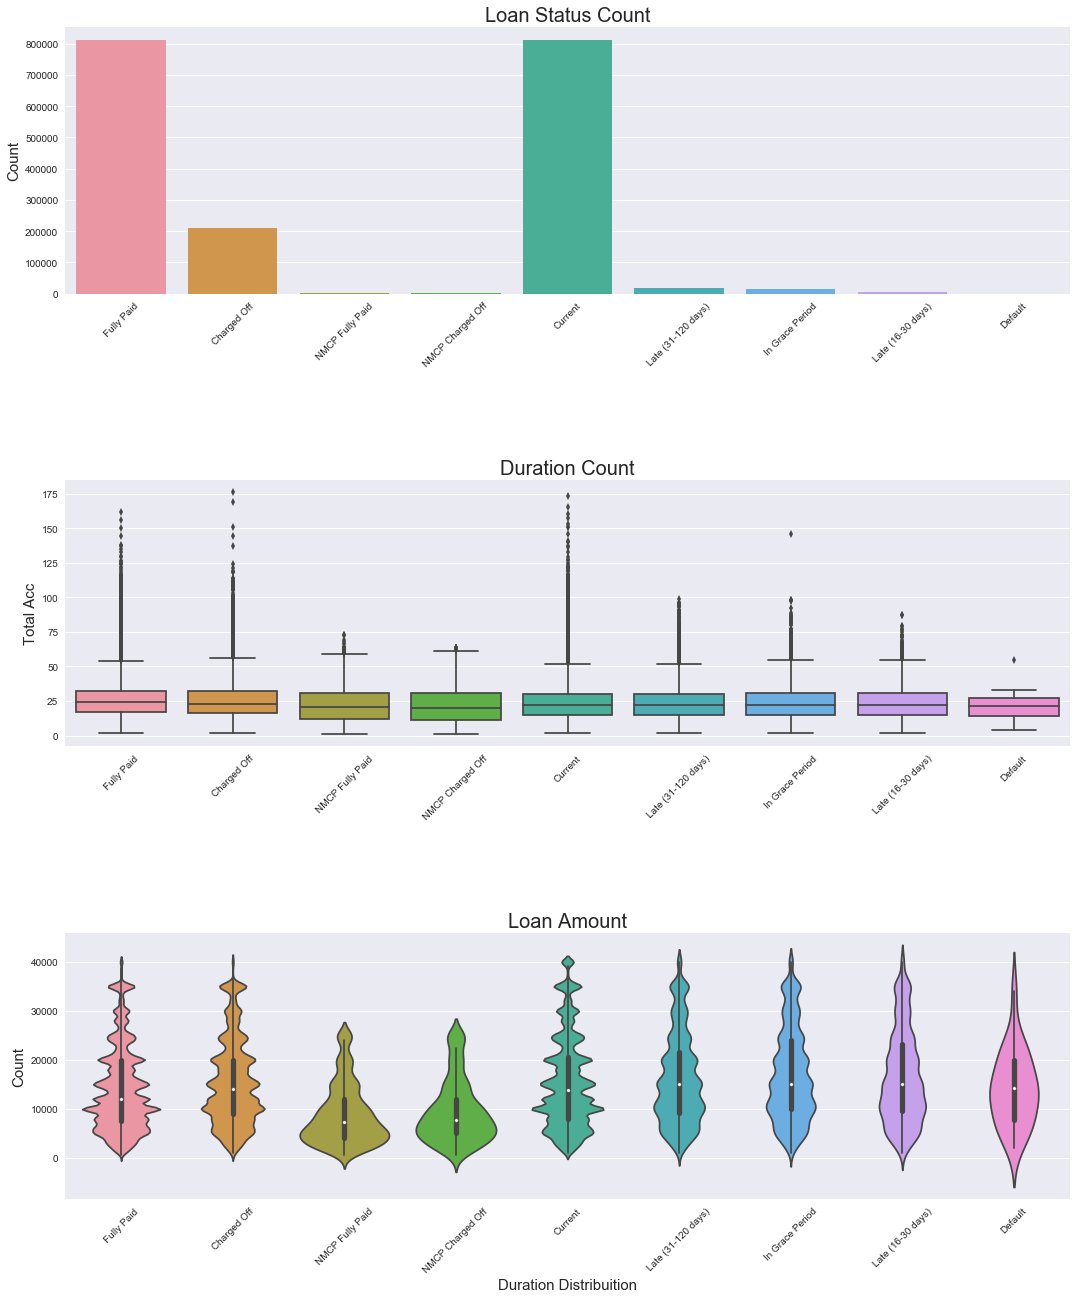

In [163]:
print(df.loan_status.value_counts())

plt.figure(figsize = (18,21))

plt.subplot(311)
g = sns.countplot(x="loan_status", data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Loan Status Count", fontsize=20)

plt.subplot(312)
g1 = sns.boxplot(x="loan_status", y="total_acc", data=df)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Total Acc", fontsize=15)
g1.set_title("Duration Count", fontsize=20)

plt.subplot(313)
g2 = sns.violinplot(x="loan_status", y="loan_amnt", data=df)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_xlabel("Duration Distribuition", fontsize=15)
g2.set_ylabel("Count", fontsize=15)
g2.set_title("Loan Amount", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.7,top = 0.9)

plt.show()